## Load data from google drive(Must run)

In [ ]:
import os
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.models.utils import load_state_dict_from_url
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
from torchvision import models

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')

We are using GPU.


In [ ]:
# your must replace it with your drive dictionary for train.csv and tets.csv
Path='/content/drive/My Drive/DL/Assignment_2/'

#you must replace it with your dirve dictionary for all images
root='/content/drive/My Drive/DL/Assignment_2/data/'

### Transfer label into binary array

In [ ]:
import pandas as pd
import numpy as np
labels=pd.read_csv(Path+"train.csv")
labels_test=pd.read_csv(Path+"test.csv")

In [ ]:
# transfer label [3,8,13]  to multi-onehot [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0., 0.]
def labelToneHot(item):
    label=list(map(int,item.split()))
    temp=np.zeros(20)
    temp[label]=1
    return temp[1:]
Target=[]
for item in labels['Labels']:
    Target.append(labelToneHot(item))
# list to np.array
Target_=np.array(Target)

# CNN part

## Creat dataloader for CNN(Must run)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from skimage import io
from PIL import Image
# define a dataset to combine image with label (one by one)
class CustomerDataset(Dataset):
    def __init__(self, Target, ImageID,root_dir, transform=None):
        self.landmarks_frame = Target
        self.root_dir = root_dir
        self.transform = transform
        self.imageId=ImageID
    def __len__(self):
        lenght=40000
        return len(self.landmarks_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.imageId.iloc[idx])
        image = Image.open(img_name)
        landmarks = self.landmarks_frame[idx, :]
        if self.transform:
            image = self.transform(image)
        return [image,landmarks]

#define a dataset for test ( image with empty label.)
class TestDataset(Dataset):
    def __init__(self,root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        lenght=40000
        return lenght
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                str(idx)+'.jpg')
        image = Image.open(img_name)
       # image=torch.from_numpy(image).long()
        landmarks = np.zeros(19)
        if self.transform:
            image = self.transform(image)
        return [image,landmarks]

In [ ]:


# create dataset for tairn and test using transform method to normalization the iamge data
trans=transforms.Compose([
                            # transforms.RandomResizedCrop(224),
                            transforms.Resize((224,224)),
                            # transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                          
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])
CustomerDataset=CustomerDataset(Target=Target_,ImageID=labels['ImageID'],root_dir=root,transform=trans)
TestDataset=TestDataset(root_dir=root,transform=trans)

In [ ]:
# create dataloaders
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
part=1
trainRange = list(range(0,29000//part))
validateRange = list(range(29000//part,30000//part))
testRange=list(range(30000,40000))
trainDataSet = torch.utils.data.Subset(CustomerDataset, trainRange)
validateDataSet = torch.utils.data.Subset(CustomerDataset, validateRange)
testDatsSet= torch.utils.data.Subset(TestDataset, testRange)

train_loader = torch.utils.data.DataLoader(trainDataSet,shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(validateDataSet,shuffle=False, **kwargs)
Realtest_loader=torch.utils.data.DataLoader(testDatsSet,shuffle=False,batch_size=20,num_workers=6)
print('Dataloaders initialized.')

Dataloaders initialized.


29008 examples in the training set.
1008 examples in the testing set.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


A batch of imgs shape: torch.Size([16, 3, 224, 224])
A batch of labels shape: torch.Size([16, 19])


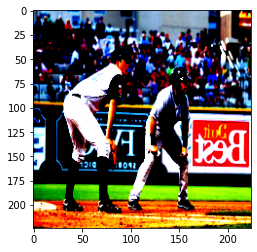

In [ ]:
print('{} examples in the training set.'.format(len(train_loader) * 16))
print('{} examples in the testing set.'.format(len(test_loader) * 16))

b_imgs,b_labels= next(iter(train_loader))

print('A batch of imgs shape:', b_imgs.size())
print('A batch of labels shape:', b_labels.size())

plt.imshow(b_imgs[0].transpose(0, 1).transpose(1, 2))
            # * torch.tensor([0.229, 0.224, 0.225])
            # + torch.tensor([0.485, 0.456, 0.406]))

## Common function (Must run)

In [ ]:
#calculate the accuracy and recall
def calculate_acuracy_mode_one(model_pred, labels):
    accuracy_th = 0.5
    pred_result = model_pred > accuracy_th
    pred_result = pred_result.float()
    pred_one_num = torch.sum(pred_result)
    if pred_one_num == 0:
        return 0, 0
    target_one_num = torch.sum(labels)
    true_predict_num = torch.sum(pred_result * labels)
    precision = true_predict_num / pred_one_num
    recall = true_predict_num / target_one_num
    return precision.item(), recall.item()

In [ ]:
# def a evaluation for validation phase
def evaluation(model): 
        if torch.cuda.is_available():
            model = model.to('cuda')
            print('using GPU')
        else:
            print('using CPU')
        ## set model to evaluation mode
        model.eval()
        ## evaluation
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        criterion=nn.BCEWithLogitsLoss()
        with torch.no_grad():
            for step,(x,y) in enumerate(test_loader):
                x=x.float()
                y=y.float()
                if torch.cuda.is_available():
                    x = x.to('cuda')
                    y = y.to('cuda')
                # calculate output
                p = model(x)
                # calculate metrics
                loss = criterion(p, y)

                pred = F.sigmoid(p)
                target = (y)
                acc,recall= calculate_acuracy_mode_one(pred,target)
                # acc = accuracy(p, y)
                ep_loss += loss
                ep_acc += acc
                ep_recall +=recall
                if step % 5 == 0:
                    print('\rtest step: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f' 
                            % (step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                               2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                               ), end='')
        print('\ntest loss: %.2f acc: %.4f recall: %.4f F1: %.4f'
                % (ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                   2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))))

In [ ]:
# create test file for kaggle
def testOutput(model):
    if torch.cuda.is_available():
        model = model.to('cuda')
        print('using GPU')
    else:
        print('using CPU')
    ## set model to evaluation mode
    model.eval()
    ## evaluation
    ep_loss = 0.0
    ep_acc = 0.0
    pred_list=[]
    with torch.no_grad():
        for step,(x,y) in enumerate(Realtest_loader):
            x=x.float()
            if torch.cuda.is_available():
                x = x.to('cuda')
            # calculate output
            p = model(x)
            pred = F.sigmoid(p)>0.5
            pred_list.append(pred)

            if step % 5 == 0:
                print('\rtest step: %d '%step, end='')
    return pred_list
def vector_to_label(vec):
    output=[]
    for block in vec:
        for label in block:
            string=''
            for i in range(len(label)):
                if label[i] ==True:
                    string += ' ' + str(i+1)
            string = string.strip()
            output.append(string)
    return output
def saveTestLabelFile(model,filename='test_label_1.csv'):
    out=testOutput(model)
    pre_lsit=vector_to_label(out)
    test_image_list=labels_test['ImageID']
    dataFrame=pd.DataFrame({'ImageID':test_image_list,'Labels':pre_lsit})
    dataFrame.to_csv(filename,index=False,sep=',')

## Alexnet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, stem_stride=4):
        # invoke super class initialisation method
        super(AlexNet, self).__init__()
        
        # define the CNN:
        # 1. define feature extraction layers
        self.features = nn.Sequential(
            # conv-relu-pooling
            nn.Conv2d(3, 64, kernel_size=11, stride=stem_stride, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-pooling
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv-relu-conv-relu-conv-relu-pooling
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # 2. define average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # 3. define fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),                   # use dropout
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),                   # use dropout
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            # nn.Softmax(),  # steven add
        )

    # define forward-propagation
    def forward(self, x):
        # feature extraction
        x = self.features(x)
        # adaptive pooling
        x = self.avgpool(x)
        # flat the feature map
        x = torch.flatten(x, 1)
        # classification
        x = self.classifier(x)
        # x= F.sigmoid(x)
        return x

In [ ]:
# pretrained model url
alexnet_url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
# create a network
model_pre = AlexNet()
# load pretrained network from url
state_dict = load_state_dict_from_url(alexnet_url)
model_pre.load_state_dict(state_dict)
model= nn.Sequential(model_pre,nn.Linear(1000, 19)) # Use it as usual out = model(input)
if torch.cuda.is_available():
    print('using GPU')
    model = model.to('cuda')
else:
    print('using CPU')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



using GPU


In [ ]:
from sklearn.metrics import accuracy_score
from torch.optim import lr_scheduler
learning_rate = 0.001
epochs = 5

# utilise GPU
if torch.cuda.is_available():
    model = model.to('cuda')
    print('using GPU')
else:
    print('using CPU')

# define optimizer
# optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,weight_decay =1e-8) 
# optimizer = torch.optim.Adam(model.parameters(), learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# define loss function
criterion = nn.BCEWithLogitsLoss()
# training
## set model to training mode
model.train()
## start training
for ep in range(epochs):
    ep_loss = 0.0
    ep_acc = 0.0
    ep_recall=0.0
    for step, (x,y) in enumerate(train_loader):
        x=x.float()
        y=y.float()
        if torch.cuda.is_available():
            # print('cuda')
            x = x.to('cuda')
            y = y.to('cuda')
        # set gradient to zero        
        optimizer.zero_grad()
        # calculate output
        p = model(x)
        # calculate metrics
        loss = criterion(p, y)
        pred = F.sigmoid(p)
        target = (y)
        acc ,recall= calculate_acuracy_mode_one(pred,target)
        ep_loss += loss
        ep_acc += acc
        ep_recall+=recall
        # back-prop
        loss.backward()  
        # update parameters
        optimizer.step()
        if step % 5 == 0:
            print('\repoch: %d step: %d loss: %.8f acc: %.4f recall: %.4f'
                  % (ep, step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1)), end='')
    exp_lr_scheduler.step()
    print('\nepoch: %d loss: %.2f acc: %.4f recall: %.4f'
          % (ep, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1)))  

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 0 step: 1810 loss: 0.15377782 acc: 0.7954 recall: 0.5315
epoch: 0 loss: 0.15 acc: 0.7953 recall: 0.5315
epoch: 1 step: 1810 loss: 0.13502792 acc: 0.8220 recall: 0.5671
epoch: 1 loss: 0.13 acc: 0.8221 recall: 0.5673
epoch: 2 step: 1810 loss: 0.13047019 acc: 0.8282 recall: 0.5824
epoch: 2 loss: 0.13 acc: 0.8281 recall: 0.5823
epoch: 3 step: 1810 loss: 0.12828237 acc: 0.8316 recall: 0.5842
epoch: 3 loss: 0.13 acc: 0.8316 recall: 0.5842
epoch: 4 step: 1810 loss: 0.12621318 acc: 0.8350 recall: 0.5936
epoch: 4 loss: 0.13 acc: 0.8351 recall: 0.5936


In [ ]:
# save model
torch.save(model.state_dict(), Path+'alexnet1')

In [ ]:
# load model
model_pre = AlexNet()
alexnet= nn.Sequential(model_pre,nn.Linear(1000, 19)) 
alexnet.load_state_dict(torch.load(Path+'alexnet1'))

<All keys matched successfully>

In [ ]:
# validation
evaluation(alexnet)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.14 acc: 0.7837 recall: 0.6107 F1: 0.6864
test loss: 0.14 acc: 0.7859 recall: 0.6132 F1: 0.6889


In [ ]:
# output csv file 
saveTestLabelFile(alexnet,'test_label_alexnet.csv')

## VGG

In [ ]:
#standard VGG model stucture
#reference: https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        # x= torch.sigmoid(x)    # steven add
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg19_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

In [ ]:
# load pretrained model and add an last layer for 19 classes
model_pre = vgg19_bn(pretrained=True)
vggmodel= nn.Sequential(model_pre,nn.Linear(1000, 19))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


In [ ]:
learning_rate = 0.1
epochs = 5
# utilise GPU
if torch.cuda.is_available():
    vggmodel = vggmodel.to('cuda')
    print('using GPU')
else:
    print('using CPU')
# define optimizer
optimizer = torch.optim.SGD(vggmodel.parameters(), learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# define loss function
criterion = nn.BCEWithLogitsLoss()
# training
## set model to training mode
vggmodel.train()
## start training
for ep in range(epochs):
    ep_loss = 0.0
    ep_acc = 0.0
    ep_recall=0.0
    for step, (x,y) in enumerate(train_loader):
        x=x.float()
        y=y.float()
        if torch.cuda.is_available():
            x = x.to('cuda')
            y = y.to('cuda')
        # set gradient to zero        
        optimizer.zero_grad()
        # calculate output
        p = vggmodel(x)
        loss = criterion(p, y)
        pred = torch.sigmoid(p)
        target = (y)
        acc,recall = calculate_acuracy_mode_one(pred,target)
        ep_loss += loss
        ep_acc += acc
        ep_recall +=recall
        # back-prop
        loss.backward()
        # update parameters
        optimizer.step()
        if step % 5 == 0:
            print('\repoch: %d step: %d loss: %.2f acc: %.4f recall: %.4f'
                  % (ep, step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1)), end='')
    exp_lr_scheduler.step()
    print('\nepoch: %d loss: %.2f acc: %.4f'
          % (ep, ep_loss/(step+1), ep_acc/(step+1)))

using GPU
epoch: 0 step: 1810 loss: 0.15 acc: 0.8103 recall: 0.5419
epoch: 0 loss: 0.15 acc: 0.8104
epoch: 1 step: 1810 loss: 0.11 acc: 0.8539 recall: 0.6406
epoch: 1 loss: 0.11 acc: 0.8539
epoch: 2 step: 1810 loss: 0.10 acc: 0.8693 recall: 0.6808
epoch: 2 loss: 0.10 acc: 0.8692
epoch: 3 step: 1810 loss: 0.09 acc: 0.8807 recall: 0.7093
epoch: 3 loss: 0.09 acc: 0.8807
epoch: 4 step: 1810 loss: 0.09 acc: 0.8898 recall: 0.7351
epoch: 4 loss: 0.09 acc: 0.8898


In [ ]:
#validation
evaluation(vggmodel)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.11 acc: 0.8389 recall: 0.6577 F1: 0.7373
test loss: 0.11 acc: 0.8398 recall: 0.6584 F1: 0.7381


In [ ]:
# save model parameters
torch.save(vggmodel.state_dict(), Path+'vgg1')

In [ ]:
# load model parameters
model_pre = vgg19_bn(pretrained=False)
vggmodel= nn.Sequential(model_pre,nn.Linear(1000, 19)) 
vggmodel.load_state_dict(torch.load(Path+'vgg1'))

<All keys matched successfully>

In [ ]:
# create test file for kaggle
saveTestLabelFile(vggmodel,'test_label_vgg1.csv')

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 495 

## ResNet

### preparation (Must run)

In [ ]:
#reference: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


In [ ]:
from sklearn.metrics import accuracy_score
learning_rate = 0.001
epochs = 5

# using pretrained
# resmodel=resmodel
def training_resnet(resmodel):
    # utilise GPU
    if torch.cuda.is_available():
        resmodel = resmodel.to('cuda')
        print('using GPU')
    else:
        print('using CPU')

    # define optimizer
    optimizer = torch.optim.SGD(resmodel.parameters(), learning_rate, momentum=0.9,weight_decay =1e-8)
    # optimizer = torch.optim.Adam(resmodel.parameters(), learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # define loss function
    criterion = nn.BCEWithLogitsLoss()

    # training
    ## set model to training mode
    resmodel.train()
    ## start training
    for ep in range(epochs):
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        for step, (x,y) in enumerate(train_loader):
            x=x.float()
            y=y.float()
            if torch.cuda.is_available():
                x = x.to('cuda')
                y = y.to('cuda')
            # set gradient to zero        
            optimizer.zero_grad()
            # calculate output
            p = resmodel(x)
            loss = criterion(p, y)
            pred = (p)
            target = (y)
            acc,recall = calculate_acuracy_mode_one(pred,target)
            ep_loss += loss
            ep_acc += acc
            ep_recall+=recall
            # back-prop
            loss.backward()
            # update parameters
            optimizer.step()
            if step % 5 == 0:
                print('\rtest step: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f' 
                            % (step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                               2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                               ), end='')
        exp_lr_scheduler.step()
        print('\nepoch: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f'
            % (ep, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
               2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
               ))
        
    return resmodel

In [ ]:
# load pretrained model
model_pre_50 = models.resnet.resnet50(pretrained=True)
resmodel_50= nn.Sequential(model_pre_50,nn.Linear(1000, 19)) 

model_pre = models.resnet.resnet101(pretrained=True)
resmodel_101= nn.Sequential(model_pre,nn.Linear(1000, 19)) 

model_pre_152 = models.resnet.resnet152(pretrained=True)
resmodel_152= nn.Sequential(model_pre_152,nn.Linear(1000, 19)) 


### res50

In [ ]:
#training
resmodel_50 = training_resnet(resmodel_50)

using GPU
test step: 1810 loss: 0.12 acc: 0.8992 recall: 0.5479 F1: 0.6809
epoch: 0 loss: 0.12 acc: 0.8990 recall: 0.5480 F1: 0.6810
test step: 1810 loss: 0.11 acc: 0.9120 recall: 0.6056 F1: 0.7279
epoch: 1 loss: 0.11 acc: 0.9120 recall: 0.6057 F1: 0.7279
test step: 1810 loss: 0.10 acc: 0.9179 recall: 0.6259 F1: 0.7443
epoch: 2 loss: 0.10 acc: 0.9179 recall: 0.6258 F1: 0.7442
test step: 1810 loss: 0.10 acc: 0.9219 recall: 0.6344 F1: 0.7516
epoch: 3 loss: 0.10 acc: 0.9217 recall: 0.6342 F1: 0.7514
test step: 1810 loss: 0.10 acc: 0.9237 recall: 0.6427 F1: 0.7580
epoch: 4 loss: 0.10 acc: 0.9237 recall: 0.6428 F1: 0.7581


In [ ]:
#valiadation
evaluation(resmodel_50)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.10 acc: 0.8671 recall: 0.7157 F1: 0.7842
test loss: 0.10 acc: 0.8686 recall: 0.7150 F1: 0.7843


In [ ]:
# save model
torch.save(resmodel_50.state_dict(), Path+'resnet50')

In [ ]:
# load model parameters
model_pre_50 = models.resnet.resnet50(pretrained=True)
resmodel_50= nn.Sequential(model_pre_50,nn.Linear(1000, 19)) 
resmodel_50 = resmodel_50.load_state_dict(torch.load(Path+'resnet50'))

### res101

In [ ]:
#training
resmodel_101 = training_resnet(resmodel_101)

using GPU
test step: 1810 loss: 0.10 acc: 0.9088 recall: 0.6580 F1: 0.7633
epoch: 0 loss: 0.10 acc: 0.9087 recall: 0.6579 F1: 0.7632
test step: 1810 loss: 0.07 acc: 0.9374 recall: 0.7384 F1: 0.8261
epoch: 1 loss: 0.07 acc: 0.9375 recall: 0.7384 F1: 0.8261
test step: 1810 loss: 0.06 acc: 0.9472 recall: 0.7810 F1: 0.8561
epoch: 2 loss: 0.06 acc: 0.9472 recall: 0.7810 F1: 0.8561
test step: 1810 loss: 0.05 acc: 0.9549 recall: 0.8123 F1: 0.8778
epoch: 3 loss: 0.05 acc: 0.9549 recall: 0.8123 F1: 0.8779
test step: 1810 loss: 0.04 acc: 0.9601 recall: 0.8390 F1: 0.8955
epoch: 4 loss: 0.04 acc: 0.9602 recall: 0.8391 F1: 0.8955


In [ ]:
#save model
torch.save(resmodel_101.state_dict(), Path+'resnet101')

In [ ]:
# load model parameters
model_pre = models.resnet.resnet101(pretrained=True)
resmodel_101= nn.Sequential(model_pre,nn.Linear(1000, 19)) 
resmodel_101.load_state_dict(torch.load(Path+'resnet101'))

<All keys matched successfully>

In [ ]:
#validation
evaluation(resmodel_101)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.10 acc: 0.8621 recall: 0.7763 F1: 0.8170
test loss: 0.10 acc: 0.8604 recall: 0.7782 F1: 0.8172


### res152

In [ ]:
#training
resmodel_152 = training_resnet(resmodel_152)

using GPU
test step: 1810 loss: 0.12 acc: 0.9025 recall: 0.5741 F1: 0.7018
epoch: 0 loss: 0.12 acc: 0.9024 recall: 0.5742 F1: 0.7019
test step: 1810 loss: 0.09 acc: 0.9320 recall: 0.6725 F1: 0.7812
epoch: 1 loss: 0.09 acc: 0.9320 recall: 0.6725 F1: 0.7813
test step: 1810 loss: 0.08 acc: 0.9376 recall: 0.7046 F1: 0.8046
epoch: 2 loss: 0.08 acc: 0.9375 recall: 0.7046 F1: 0.8046
test step: 1810 loss: 0.07 acc: 0.9450 recall: 0.7275 F1: 0.8221
epoch: 3 loss: 0.07 acc: 0.9449 recall: 0.7274 F1: 0.8220
test step: 1810 loss: 0.07 acc: 0.9495 recall: 0.7481 F1: 0.8368
epoch: 4 loss: 0.07 acc: 0.9495 recall: 0.7481 F1: 0.8369


In [ ]:
#save model
torch.save(resmodel_152.state_dict(), Path+'resnet152')

In [ ]:
# load model parameters
model_pre_152 = models.resnet.resnet152(pretrained=True)
resmodel_152= nn.Sequential(model_pre_152,nn.Linear(1000, 19)) 
resmodel_152.load_state_dict(torch.load(Path+'resnet152'))

<All keys matched successfully>

In [ ]:
#validation
evaluation(resmodel_152)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.08 acc: 0.8915 recall: 0.7837 F1: 0.8341
test loss: 0.08 acc: 0.8934 recall: 0.7836 F1: 0.8349


# RNN part

## Data pretreatment(Must run)

In [ ]:
# load data 
labels_lstm=pd.read_csv(Path+"train.csv")
labels_test_lstm=pd.read_csv(Path+"test.csv")
train_caption_list=labels['Caption'].tolist()
test_caption_list=labels_test['Caption'].tolist()
Target=[]
for item in labels['Labels']:
    Target.append(labelToneHot(item))

In [ ]:
#get all sentences
keeps = [chr(i) for i in range(97,123)] + [" "]
all_sentences=[]
for review in train_caption_list + test_caption_list:
    all_sentences.extend(list(review.lower()))

In [ ]:
# generate romove word list
remove_char = []
all_char_list = list(set(all_sentences))
for i in all_char_list:
  if i not in keeps:
    remove_char.append(i)

remove_chars = "".join(remove_char)
print(remove_chars)

In [ ]:
from nltk import stem
import string
from gensim.parsing.preprocessing import remove_stopwords
Porter = stem.PorterStemmer()
#token/stem/stopword_remove/ porcess
def data_pre(sentence_list):
  sentences = []
  # this is a-z and space
  for sentence in sentence_list:
    # create a remove table for invalid character
    remove = remove_chars
    # There are some useless char in the sentence, so here I add and delete the data
    replace = " " * len(remove)
    # make a translate table
    remove_table = str.maketrans(remove , replace)
    # clean punctuation and digits
    sentence_replace = sentence.lower().translate(remove_table)
    #clean stopwords and tokenize
    sentence_replace = remove_stopwords(sentence_replace).split()
    #remove meaningless tokens  also remove some HTML language
    sentence_new = []
    for token in sentence_replace:
      # I think if a word are longer than 20, it have a great possiblity as a invalid word, and shorter than 2,it may be a stopword
      # so i only get the word that the length are form 2 to 20.
      if len(token) > 2 and len(token)<20:
        # lemmatizer, let the word become it's original shape, had --> have
        sentence_new.append(Porter.stem(token))
    sentences.append(sentence_new)
  return sentences


In [ ]:
# used the data_pre method that defind above
train_data = data_pre(train_caption_list)
test_data = data_pre(test_caption_list)

In [ ]:
# text_train_ns
# Data after word segmentation has been processed
len_list = [len(s) for s in train_data]
#seq_length，Is the length of the sublist with the most words.
seq_length = max(len_list)

# add_padding
# The function of the function is to fill in the blanks, 
# the purpose is to fill the length of all the sublists to a consistent length, 
# which uses <PAD> as the filling content.
def add_padding(corpus, seq_length):
    output = []
    for sentence in corpus:
        if len(sentence)>seq_length:
            output.append(sentence[:seq_length])
        else:
            for j in range(seq_length-len(sentence)):
                sentence.append("<PAD>")
            output.append(sentence)
    return output

text_train_pad = add_padding(train_data,seq_length )
text_test_pad = add_padding(test_data,seq_length )
print(len(text_train_pad))

In [ ]:
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-100")

In [ ]:
def get_embeddings(corpus,word_emb_model):
    emb_dim = word_emb_model.vector_size
    out = []
    for sentence in corpus:
        out_temp = []
        for word in sentence:
            try:
                out_temp.append(word_emb_model.wv[word])
            except:
                out_temp.append([0]*emb_dim)
    
        out.append(out_temp)
    return np.array(out)

#embeddings
train_emb = get_embeddings(text_train_pad,word_emb_model)
test_emb = get_embeddings(text_test_pad,word_emb_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
# with open('/content/drive/My Drive/DL/Assignment_2/train_test_emb.npy', 'wb') as f:
#     np.save(f, train_emb)
#     np.save(f, test_emb)

In [ ]:

with open('/content/drive/My Drive/DL/Assignment_2/train_test_emb.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
print(a.shape, b.shape)
train_emb=a
test_emb=b

(30000, 26, 100) (10000, 26, 100)


In [ ]:
from sklearn.model_selection import train_test_split
sent_train, sent_val, label_train, label_val = train_test_split(train_emb, np.array(Target), test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class trainset(Dataset):
    def __init__(self,senetance,target):
        
        self.senetance = senetance
        self.target = target

    def __getitem__(self, index):
        senetance = self.senetance[index]
        target = self.target[index]
        return senetance,target

    def __len__(self):
        return len(self.senetance)

#create dataloader
train_data = trainset(senetance=sent_train,target=label_train)
trainloader = DataLoader(train_data, batch_size =16, shuffle = True, num_workers=6,pin_memory=True)
validate_data= trainset(senetance=sent_val,target=label_val)
validateloader = DataLoader(validate_data, batch_size =16, shuffle = True, num_workers=6,pin_memory=True)

In [ ]:
#define training function
def train_lstm(blstm):
    epoch = 10
    learning_rate = 0.001
    device = torch.device("cuda" if  torch.cuda.is_available() else "cpu")
    # print(device)


    if torch.cuda.is_available():
        blstm = blstm.to('cuda')
        print('using GPU')
    else:
        print('using CPU')

    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(blstm.parameters(), lr=learning_rate,weight_decay =1e-8)
    # optimizer = torch.optim.SGD(blstm.parameters(), learning_rate, momentum=0.9,weight_decay =1e-10)
    # optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    batch_num = 0
    blstm.train()
    for ep in range(epoch):
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        for batch,(x,y) in enumerate(trainloader):
            # x_torch = x.to(device)
            # y_torch = y.to(device)
            y = y.to(device).float()
            x = x.to(device).float()
            
            optimizer.zero_grad()
            outputs = blstm(x)
            loss = criterion(outputs,y)
            loss.backward()
            optimizer.step()
            #batch_num += 1

            pred = F.sigmoid(outputs)
            target = (y)
            # print('pred:',pred)
            # print('target:',target)
            acc,recall = calculate_acuracy_mode_one(pred,target)
            # acc = accuracy(p, y)

            # loss=(loss*weight).mean()
            ep_loss += loss
            ep_acc += acc
            ep_recall+=recall
            if batch % 100 == 0:
                print('\rtest step: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f' 
                            % (batch, ep_loss/(batch+1), ep_acc/(batch+1),ep_recall/(batch+1),
                               2*ep_acc/(batch+1)*ep_recall/(batch+1)/(ep_acc/(batch+1)+ep_recall/(batch+1))
                               ), end='')
        exp_lr_scheduler.step()
        print('\nepoch: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f'
            % (ep, ep_loss/(batch+1), ep_acc/(batch+1),ep_recall/(batch+1),
               2*ep_acc/(batch+1)*ep_recall/(batch+1)/(ep_acc/(batch+1)+ep_recall/(batch+1))
               ))
    return blstm
        

In [ ]:
#define validation function
def evaluation_lstm(model): 
        if torch.cuda.is_available():
            model = model.to('cuda')
            print('using GPU')
        else:
            print('using CPU')

        ## set model to evaluation mode
        model.eval()
        ## evaluation
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        criterion=nn.BCEWithLogitsLoss()
        with torch.no_grad():
            for step,(x,y) in enumerate(validateloader):
                x=x.float()
                y=y.float()
                if torch.cuda.is_available():
                    x = x.to('cuda')
                    y = y.to('cuda')
                # calculate output
                p = model(x)
                # calculate metrics
                loss = criterion(p, y)

                pred = F.sigmoid(p)
                target = (y)
                acc ,recall= calculate_acuracy_mode_one(pred,target)
                # acc = accuracy(p, y)
                ep_loss += loss
                ep_acc += acc
                ep_recall+=recall
                if step % 5 == 0:
                    print('\rtest step: %d loss: %.2f acc: %.4f recall: %.4f'
                            % (step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1)), end='')
        print('\ntest loss: %.2f acc: %.4f recall: %.4f'
                % (ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1)))

In [ ]:
 q

In [ ]:
n_input = train_emb.shape[2]
n_hidden = 100
n_class = 19
num_layers= 2
total_epoch = 10
learning_rate = 0.01
class Lstm_Net_2(nn.Module):
    def __init__(self):
        super(Lstm_Net_2, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers,batch_first =True,bidirectional=True, dropout=0.3)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, sentence):
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)#concatnate as colunm(left-right)
        z = self.linear(hidden_out)

        return z

In [ ]:
n_input = train_emb.shape[2]
n_hidden = 100
n_class = 19
num_layers= 3
total_epoch = 10
learning_rate = 0.01
class Lstm_Net_3(nn.Module):
    def __init__(self):
        super(Lstm_Net_3, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers,batch_first =True,bidirectional=True, dropout=0.3)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, sentence):
        
        #h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        #concat the last hidden state from two direction
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)#concatnate as colunm(left-right)
        z = self.linear(hidden_out)

        return z

## BLSTM(2layers)

In [ ]:
#training model
blstm_2 = Lstm_Net_2().to(device)
blstm_2 = train_lstm(blstm_2)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 1400 loss: 0.14 acc: 0.8767 recall: 0.5599 F1: 0.6834
epoch: 0 loss: 0.14 acc: 0.8786 recall: 0.5679 F1: 0.6899
test step: 1400 loss: 0.10 acc: 0.9117 recall: 0.6979 F1: 0.7906
epoch: 1 loss: 0.10 acc: 0.9116 recall: 0.6991 F1: 0.7913
test step: 1400 loss: 0.09 acc: 0.9191 recall: 0.7208 F1: 0.8080
epoch: 2 loss: 0.09 acc: 0.9191 recall: 0.7210 F1: 0.8081
test step: 1400 loss: 0.08 acc: 0.9242 recall: 0.7330 F1: 0.8176
epoch: 3 loss: 0.08 acc: 0.9237 recall: 0.7329 F1: 0.8173
test step: 1400 loss: 0.08 acc: 0.9272 recall: 0.7393 F1: 0.8226
epoch: 4 loss: 0.08 acc: 0.9276 recall: 0.7403 F1: 0.8234
test step: 1400 loss: 0.07 acc: 0.9390 recall: 0.7530 F1: 0.8358
epoch: 5 loss: 0.07 acc: 0.9389 recall: 0.7538 F1: 0.8363
test step: 1400 loss: 0.07 acc: 0.9382 recall: 0.7560 F1: 0.8373
epoch: 6 loss: 0.07 acc: 0.9383 recall: 0.7573 F1: 0.8381
test step: 1400 loss: 0.07 acc: 0.9399 recall: 0.7589 F1: 0.8398
epoch: 7 loss: 0.07 acc: 0.9402 recall: 0.7590 F1: 0.8399
test step: 1400 

In [ ]:
#save model
torch.save(blstm_2.state_dict(), Path+'blstm_3')

In [ ]:
#load model
blstm_2 = Lstm_Net_2().to(device)
blstm_2.load_state_dict(torch.load(Path+'blstm_3'))

<All keys matched successfully>

In [ ]:
#validation
evaluation_lstm(blstm_2)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 370 loss: 0.09 acc: 0.9197 recall: 0.7267
test loss: 0.09 acc: 0.9203 recall: 0.7272


In [ ]:
#output csv file
outputFile(blstm_2,'test_label_lstm2.csv')

## BLSTM(3layers)

In [ ]:
#train model
blstm_3 = Lstm_Net_3().to(device)
blstm_3 = train_lstm(blstm_3)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 1400 loss: 0.14 acc: 0.8778 recall: 0.5544 F1: 0.6796
epoch: 0 loss: 0.14 acc: 0.8795 recall: 0.5615 F1: 0.6854
test step: 1400 loss: 0.10 acc: 0.9139 recall: 0.6949 F1: 0.7895
epoch: 1 loss: 0.10 acc: 0.9138 recall: 0.6959 F1: 0.7901
test step: 1400 loss: 0.09 acc: 0.9176 recall: 0.7211 F1: 0.8076
epoch: 2 loss: 0.09 acc: 0.9180 recall: 0.7218 F1: 0.8082
test step: 1400 loss: 0.08 acc: 0.9219 recall: 0.7337 F1: 0.8171
epoch: 3 loss: 0.08 acc: 0.9215 recall: 0.7329 F1: 0.8164
test step: 1400 loss: 0.08 acc: 0.9270 recall: 0.7402 F1: 0.8232
epoch: 4 loss: 0.08 acc: 0.9268 recall: 0.7401 F1: 0.8230
test step: 1400 loss: 0.08 acc: 0.9360 recall: 0.7522 F1: 0.8341
epoch: 5 loss: 0.08 acc: 0.9360 recall: 0.7518 F1: 0.8338
test step: 1400 loss: 0.07 acc: 0.9366 recall: 0.7552 F1: 0.8362
epoch: 6 loss: 0.07 acc: 0.9362 recall: 0.7553 F1: 0.8360
test step: 1400 loss: 0.07 acc: 0.9371 recall: 0.7583 F1: 0.8383
epoch: 7 loss: 0.07 acc: 0.9367 recall: 0.7576 F1: 0.8377
test step: 1400 

In [ ]:
#save model
torch.save(blstm_3.state_dict(), Path+'blstm_4')

In [ ]:
#load model
blstm_3 = Lstm_Net_3().to(device)
blstm_3.load_state_dict(torch.load(Path+'blstm_4'))

<All keys matched successfully>

In [ ]:
#validation
evaluation_lstm(blstm_3)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 370 loss: 0.09 acc: 0.9131 recall: 0.7301
test loss: 0.09 acc: 0.9132 recall: 0.7300


In [ ]:
#make csv file from test dataset
outputFile(blstm_3,'test_label_lstm3.csv')

# Concat model

## common function(Must run)

In [ ]:
#define a dataset for train 
class DoubleModelDataset(Dataset):
    def __init__(self, Target, ImageID,CaptionEmb,root_dir, transform=None):
        self.landmarks_frame = Target
        self.root_dir = root_dir
        self.transform = transform
        self.imageId=ImageID
        self.captionEmb=CaptionEmb
    def __len__(self):
        lenght=40000
        return len(self.landmarks_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.imageId.iloc[idx])
        image = Image.open(img_name)
        landmarks = self.landmarks_frame[idx, :]
        caption=self.captionEmb[idx, :,:]
        if self.transform:
            image = self.transform(image)
        return [image,landmarks,caption]


#define a dataset for test ( image with empty label.)
class DoubleModelTestDataset(Dataset):
    def __init__(self,CaptionEmb,root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.captionEmb=CaptionEmb
    def __len__(self):
        lenght=40000
        return lenght
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                str(idx)+'.jpg')
        image = Image.open(img_name)
        landmarks = np.zeros(19)
        caption=self.captionEmb[idx-30000,:,:]
        if self.transform:
            image = self.transform(image)
        return [image,landmarks,caption]

In [ ]:
# create dataset for tairn and test using transform method to normalization the iamge data
trans=transforms.Compose([
                            # transforms.RandomResizedCrop(224),
                            transforms.Resize((224,224)),
                            # transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                            ])
doubleModelDataset=DoubleModelDataset(Target=Target_,ImageID=labels['ImageID'],root_dir=root,CaptionEmb=train_emb,transform=trans)
doubleModelTestDataset=DoubleModelTestDataset(CaptionEmb=test_emb,root_dir=root,transform=trans)

In [ ]:
#create dataloader
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
part=1
trainRange = list(range(0,29000//part))
validateRange = list(range(29000//part,30000//part))
testRange=list(range(30000,40000))
doubleTrainDataSet = torch.utils.data.Subset(doubleModelDataset, trainRange)#train_seleted
doubleValidateDataSet = torch.utils.data.Subset(doubleModelDataset, validateRange)
doubleTestDatsSet= torch.utils.data.Subset(doubleModelTestDataset, testRange)

double_train_loader = torch.utils.data.DataLoader(doubleTrainDataSet,shuffle=True, **kwargs)
double_test_loader = torch.utils.data.DataLoader(doubleValidateDataSet,shuffle=False, **kwargs)
doubel_Realtest_loader=torch.utils.data.DataLoader(doubleTestDatsSet,shuffle=False,batch_size=20,num_workers=8)
print('Dataloaders initialized.')

Dataloaders initialized.


In [ ]:
def train_double_model(doubleModel,epochs=5):
    learning_rate = 0.001
    
    # utilise GPU
    if torch.cuda.is_available():
        doubleModel = doubleModel.to('cuda')
        print('using GPU')
    else:
        print('using CPU')
    # define optimizer
    optimizer = torch.optim.SGD(doubleModel.parameters(), learning_rate, momentum=0.9,weight_decay =1e-8)
    # optimizer = torch.optim.Adam(doubleModel.parameters(), learning_rate,weight_decay =1e-8)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # define loss function
    criterion = nn.BCEWithLogitsLoss()
    ## start training
    for ep in range(epochs):
        doubleModel.train()
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        for step, (x,y,z) in enumerate(double_train_loader):
            x=x.float()
            y=y.float()
            z=z.float()
            if torch.cuda.is_available():
                # print('cuda')
                x = x.to('cuda')
                y = y.to('cuda')
                z=z.to('cuda')
            # set gradient to zero        
            optimizer.zero_grad()
            # calculate output
            p = doubleModel(x,z)
            loss = criterion(p, y)
            pred = (p)
            target = (y)
            acc,recall = calculate_acuracy_mode_one(pred,target)
            # acc = accuracy(p, y)
            ep_loss += loss
            ep_acc += acc
            ep_recall+=recall
            # back-prop
            loss.backward()
            # update parameters
            optimizer.step()
            if step % 5 == 0:
                print('\rtrain step: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f' 
                            % (step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                            2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                            ), end='')
        exp_lr_scheduler.step()        
        print('\ntrain: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f'
                % (ep, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                ))
        print('Validation:')
        evaluation_double(doubleModel)
        print('\n')
    return doubleModel



In [ ]:
#define validation function
def evaluation_double(model): 
        if torch.cuda.is_available():
            model = model.to('cuda')
            print('using GPU')
        else:
            print('using CPU')
        ## set model to evaluation mode
        model.eval()
        ## evaluation
        ep_loss = 0.0
        ep_acc = 0.0
        ep_recall=0.0
        criterion=nn.BCEWithLogitsLoss()
        with torch.no_grad():
            for step,(x,y,z) in enumerate(double_test_loader):
                x=x.float()
                y=y.float()
                z=z.float()
                if torch.cuda.is_available():
                    x = x.to('cuda')
                    y = y.to('cuda')
                    z = z.to('cuda')
                # calculate output
                p = model(x,z)
                loss = criterion(p, y)
                pred = F.sigmoid(p)
                target = (y)
                acc ,recall= calculate_acuracy_mode_one(pred,target)
                ep_loss += loss
                ep_acc += acc
                ep_recall+=recall
                if step % 5 == 0:
                    print('\rtest step: %d loss: %.2f acc: %.4f recall: %.4f F1: %.4f' 
                            % (step, ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                            2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                            ), end='')
        print('\ntest loss: %.2f acc: %.4f recall: %.4f F1: %.4f'
                % (ep_loss/(step+1), ep_acc/(step+1),ep_recall/(step+1),
                   2*ep_acc/(step+1)*ep_recall/(step+1)/(ep_acc/(step+1)+ep_recall/(step+1))
                   ))

In [ ]:
#define prediction of test dataset
def testOutput_double(model):
    if torch.cuda.is_available():
        model = model.to('cuda')
        print('using GPU')
    else:
        print('using CPU')
    ## set model to evaluation mode
    model.eval()
    ## evaluation
    ep_loss = 0.0
    ep_acc = 0.0
    pred_list=[]
    with torch.no_grad():
        for step,(x,y,z) in enumerate(doubel_Realtest_loader):
            x=x.float()
            z=z.float()
            # y=y.float()
            if torch.cuda.is_available():
                x = x.to('cuda')
                z = z.to('cuda')
            p = model(x,z)
            pred = F.sigmoid(p)>0.5
            pred_list.append(pred)
            if step % 5 == 0:
                print('\rtest step: %d '%step, end='')
    return pred_list
#transfer onehot to label
def vector_to_label(vec):
    output=[]
    for block in vec:
        for label in block:
            string=''
            for i in range(len(label)):
                if label[i] ==True:
                    string += ' ' + str(i+1)
            string = string.strip()
            output.append(string)
    return output
# create test file for kaggle
def saveTestLabelFile_double(model,filename='test_label_doublemodel.csv'):
    out=testOutput_double(model)
    pre_lsit=vector_to_label(out)

    test_image_list=labels_test['ImageID']
    dataFrame=pd.DataFrame({'ImageID':test_image_list,'Labels':pre_lsit})
    dataFrame.to_csv(filename,index=False,sep=',')

## model_0(resnet50+lstm2)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,resmodel,blstm):
        super(MyModel, self).__init__()
        self.features1 = resmodel
        self.features2 = blstm
        self.fc_out = nn.Linear(38, 19)
        
    def forward(self, x1, x2):
        x1 = self.features1(x1)       
        x2 = self.features2(x2)
        # Concatenate in dim1 (feature dimension)
        x = torch.cat((x1, x2), 1)
        x = self.fc_out(x)
        return x

In [ ]:
# using pretrained model
blstm_2 = Lstm_Net_2().to(device)
blstm_2.load_state_dict(torch.load(Path+'blstm_3'))
# using pretrained model
model_pre_50 = models.resnet.resnet50(pretrained=True)
resmodel_50= nn.Sequential(model_pre_50,nn.Linear(1000, 19))
resmodel_50.load_state_dict(torch.load(Path+'resnet50'))

doubleModel_50 = MyModel(resmodel_50,blstm_2)
doubleModel_50 = train_double_model(doubleModel_50)

using GPU
test step: 1810 loss: 0.13 acc: 0.9300 recall: 0.5551 F1: 0.6952
epoch: 0 loss: 0.13 acc: 0.9300 recall: 0.5550 F1: 0.6952
test step: 1810 loss: 0.09 acc: 0.9605 recall: 0.6632 F1: 0.7846
epoch: 1 loss: 0.09 acc: 0.9605 recall: 0.6632 F1: 0.7846
test step: 1810 loss: 0.08 acc: 0.9617 recall: 0.6973 F1: 0.8084
epoch: 2 loss: 0.08 acc: 0.9618 recall: 0.6974 F1: 0.8085
test step: 1810 loss: 0.07 acc: 0.9645 recall: 0.7154 F1: 0.8215
epoch: 3 loss: 0.07 acc: 0.9645 recall: 0.7153 F1: 0.8214
test step: 1810 loss: 0.07 acc: 0.9646 recall: 0.7281 F1: 0.8298
epoch: 4 loss: 0.07 acc: 0.9647 recall: 0.7281 F1: 0.8298
test step: 1810 loss: 0.07 acc: 0.9660 recall: 0.7313 F1: 0.8324
epoch: 5 loss: 0.07 acc: 0.9660 recall: 0.7313 F1: 0.8324
test step: 1810 loss: 0.07 acc: 0.9664 recall: 0.7330 F1: 0.8336
epoch: 6 loss: 0.07 acc: 0.9664 recall: 0.7330 F1: 0.8337
test step: 1810 loss: 0.07 acc: 0.9656 recall: 0.7366 F1: 0.8357
epoch: 7 loss: 0.07 acc: 0.9657 recall: 0.7366 F1: 0.8358
test s

In [ ]:
#validation
evaluation_double(doubleModel_50)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.07 acc: 0.9224 recall: 0.7644 F1: 0.8360
test loss: 0.07 acc: 0.9249 recall: 0.7620 F1: 0.8356


In [ ]:
#save model
torch.save(doubleModel_50.state_dict(), Path+'doubleModel_res50_lstm')

## model_1(resnet101+lstm2)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,resmodel,blstm):
        super(MyModel, self).__init__()
        self.features1 = resmodel
        self.features2 = blstm
        self.fc_out = nn.Linear(38, 19)
        
    def forward(self, x1, x2):
        x1 = self.features1(x1)
        x2 = self.features2(x2)
        # Concatenate in dim1 (feature dimension)
        x = torch.cat((x1, x2), 1)
        x = self.fc_out(x)
        return x

In [ ]:
# using pretrained model
blstm_2 = Lstm_Net_2().to(device)
blstm_2.load_state_dict(torch.load(Path+'blstm_3'))
# using pretrained model
model_pre = models.resnet.resnet101(pretrained=True)
resmodel= nn.Sequential(model_pre,nn.Linear(1000, 19))
resmodel.load_state_dict(torch.load(Path+'resnet101'))
# concat two model
doubleModel = MyModel(resmodel,blstm_2)
doubleModel = train_double_model(doubleModel)

using GPU
test step: 1810 loss: 0.10 acc: 0.9376 recall: 0.6428 F1: 0.7627
epoch: 0 loss: 0.10 acc: 0.9376 recall: 0.6431 F1: 0.7629

Validation:
using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.09 acc: 0.8826 recall: 0.7707 F1: 0.8229
test loss: 0.09 acc: 0.8821 recall: 0.7702 F1: 0.8224
test step: 1810 loss: 0.04 acc: 0.9789 recall: 0.8236 F1: 0.8945
epoch: 1 loss: 0.04 acc: 0.9789 recall: 0.8235 F1: 0.8945

Validation:
using GPU
test step: 60 loss: 0.08 acc: 0.9006 recall: 0.7957 F1: 0.8449
test loss: 0.08 acc: 0.8997 recall: 0.7963 F1: 0.8449
test step: 1810 loss: 0.03 acc: 0.9843 recall: 0.8724 F1: 0.9250
epoch: 2 loss: 0.03 acc: 0.9843 recall: 0.8724 F1: 0.9250

Validation:
using GPU
test step: 60 loss: 0.08 acc: 0.8921 recall: 0.8051 F1: 0.8464
test loss: 0.08 acc: 0.8921 recall: 0.8055 F1: 0.8466
test step: 1810 loss: 0.03 acc: 0.9874 recall: 0.8984 F1: 0.9408
epoch: 3 loss: 0.03 acc: 0.9874 recall: 0.8985 F1: 0.9408

Validation:
using GPU
test step: 60 loss: 0.08 acc: 0.8957 recall: 0.8037 F1: 0.8472
test loss: 0.08 acc: 0.8943 recall: 0.8035 F1: 0.8465
test step: 1810 loss: 0.02 acc: 0.9896 recall: 0.9152 F1: 0.9510
epoch: 4 loss: 0.02 acc: 0.98

In [ ]:
#save model
torch.save(doubleModel.state_dict(),Path+'doubleModel_res101_lstm2')

In [ ]:
#load model
doubleModel = MyModel(resmodel,blstm_2)
doubleModel.load_state_dict(torch.load(Path+'doubleModel_res101_lstm2'))

<All keys matched successfully>

In [ ]:
#validation
evaluation_double(doubleModel)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.08 acc: 0.9011 recall: 0.8056 F1: 0.8507
test loss: 0.08 acc: 0.8988 recall: 0.8040 F1: 0.8487


In [ ]:
#output csv file
saveTestLabelFile_double(doubleModel,'test_label_doublemodel_res_lstm.csv')

## model_2(res101+res152+lstm2+lstm3)




In [ ]:
#model for 4 pretrained models
class MyModel_multiple(nn.Module):
    def __init__(self,resmodel_1,resmodel_2,blstm_1,bltsm_2):
        super(MyModel_multiple, self).__init__()
        self.features1 = resmodel_1
        self.features2 = resmodel_2
        self.features3 = blstm_1
        self.features4 = bltsm_2
        self.fc_out = nn.Linear(19*4, 19)
        
    def forward(self, x1, x2):
        x_1 = self.features1(x1)
        x_2 = self.features2(x1)
        x_3 = self.features3(x2)
        x_4 = self.features4(x2)
        # Concatenate in dim1 (feature dimension)
        x = torch.cat((x_1, x_2 , x_3, x_4), 1)
        x = self.fc_out(x)
        return x

In [ ]:
# using pretrained model
blstm_2 = Lstm_Net_2().to(device)
blstm_2.load_state_dict(torch.load(Path+'blstm_3'))
# using pretrained model
blstm_3 = Lstm_Net_3().to(device)
blstm_3.load_state_dict(torch.load(Path+'blstm_4'))

# using pretrained model
model_pre = models.resnet.resnet101(pretrained=True)
resmodel_1= nn.Sequential(model_pre,nn.Linear(1000, 19))
resmodel_1.load_state_dict(torch.load(Path+'resnet101'))
# using pretrained model
model_pre = models.resnet.resnet152(pretrained=True)
resmodel_2= nn.Sequential(model_pre,nn.Linear(1000, 19))
resmodel_2.load_state_dict(torch.load(Path+'resnet152'))

<All keys matched successfully>

In [ ]:
# create a mix model
doubleModel_1 = MyModel_multiple(resmodel_1,resmodel_2,blstm_2,blstm_3)
doubleModel_1 = train_double_model(doubleModel_1)

using GPU
test step: 1810 loss: 0.07 acc: 0.9618 recall: 0.7770 F1: 0.8596
epoch: 0 loss: 0.07 acc: 0.9618 recall: 0.7771 F1: 0.8597

Validation:
using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.08 acc: 0.9047 recall: 0.8023 F1: 0.8505
test loss: 0.08 acc: 0.9037 recall: 0.8028 F1: 0.8503
test step: 1810 loss: 0.03 acc: 0.9886 recall: 0.9024 F1: 0.9435
epoch: 1 loss: 0.03 acc: 0.9886 recall: 0.9025 F1: 0.9436

Validation:
using GPU
test step: 60 loss: 0.08 acc: 0.8913 recall: 0.8152 F1: 0.8516
test loss: 0.08 acc: 0.8892 recall: 0.8158 F1: 0.8509
test step: 1810 loss: 0.02 acc: 0.9914 recall: 0.9251 F1: 0.9571
epoch: 2 loss: 0.02 acc: 0.9914 recall: 0.9251 F1: 0.9571

Validation:
using GPU
test step: 60 loss: 0.08 acc: 0.9072 recall: 0.8153 F1: 0.8588
test loss: 0.08 acc: 0.9040 recall: 0.8158 F1: 0.8577
test step: 1810 loss: 0.02 acc: 0.9926 recall: 0.9394 F1: 0.9653
epoch: 3 loss: 0.02 acc: 0.9926 recall: 0.9394 F1: 0.9652

Validation:
using GPU
test step: 60 loss: 0.09 acc: 0.8985 recall: 0.8155 F1: 0.8550
test loss: 0.09 acc: 0.8966 recall: 0.8161 F1: 0.8545
test step: 1810 loss: 0.01 acc: 0.9938 recall: 0.9492 F1: 0.9710
epoch: 4 loss: 0.01 acc: 0.99

In [ ]:
#save model
torch.save(doubleModel_1.state_dict(), Path+'doubleModel_res101_res152_lstm2_lstm3')

In [ ]:
#load model
doubleModel_1 = MyModel_multiple(resmodel_1,resmodel_2,blstm)
doubleModel_1.load_state_dict(torch.load( Path+'doubleModel_res101_res152_lstm2_lstm3'))

<All keys matched successfully>

In [ ]:
#validation
evaluation_double(doubleModel_1)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.09 acc: 0.9000 recall: 0.8161 F1: 0.8560
test loss: 0.09 acc: 0.8970 recall: 0.8167 F1: 0.8550


In [ ]:
#output csv file for test dataset
saveTestLabelFile_double(doubleModel_1,'test_label_doublemodel_2res_2lstm.csv')

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 495 

## model_3(vgg19+resnet152+lstm2+lstm3)

In [ ]:
#model for 4 pretrained model 
class MyModel_multiple(nn.Module):
    def __init__(self,resmodel_1,resmodel_2,blstm_1,bltsm_2):
        super(MyModel_multiple, self).__init__()
        self.features1 = resmodel_1
        self.features2 = resmodel_2
        self.features3 = blstm_1
        self.features4 = bltsm_2
        self.fc_out = nn.Linear(19*4, 19)
        
    def forward(self, x1, x2):
        x_1 = self.features1(x1)
        x_2 = self.features2(x1)
        x_3 = self.features3(x2)
        x_4 = self.features4(x2)
        # Concatenate in dim1 (feature dimension)
        x = torch.cat((x_1, x_2 , x_3, x_4), 1)
        x = self.fc_out(x)
        return x

In [ ]:
# using pretrained model
blstm_2 = Lstm_Net_2().to(device)
blstm_2.load_state_dict(torch.load(Path+'blstm_3'))
# using pretrained model
blstm_3 = Lstm_Net_3().to(device)
blstm_3.load_state_dict(torch.load(Path+'blstm_4'))
# using pretrained model
model_pre = models.resnet.resnet101(pretrained=True)
resmodel_1= nn.Sequential(model_pre,nn.Linear(1000, 19))
resmodel_1.load_state_dict(torch.load(Path+'resnet101'))
# using pretrained model
model_pre = models.resnet.resnet152(pretrained=True)
resmodel_2= nn.Sequential(model_pre,nn.Linear(1000, 19))
resmodel_2.load_state_dict(torch.load(Path+'resnet152'))
# using pretrained model
model_pre = vgg19_bn(pretrained=False)
vggmodel= nn.Sequential(model_pre,nn.Linear(1000, 19)) 
vggmodel.load_state_dict(torch.load(Path+'vgg1'))

<All keys matched successfully>

In [ ]:
# create a mix model
# doubleModel_res_vgg_lstm_lstm = MyModel_multiple(vggmodel,resmodel_2,blstm_2,blstm_3)
#train model
doubleModel_res_vgg_lstm_lstm = train_double_model(doubleModel_res_vgg_lstm_lstm,epochs=1)


using GPU
train step: 1810 loss: 0.04 acc: 0.9789 recall: 0.8512 F1: 0.9106
train: 0 loss: 0.04 acc: 0.9789 recall: 0.8511 F1: 0.9105
Validation:
using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.06 acc: 0.9266 recall: 0.8201 F1: 0.8701
test loss: 0.06 acc: 0.9289 recall: 0.8216 F1: 0.8720




In [ ]:
#save model
torch.save(doubleModel_res_vgg_lstm_lstm.state_dict(), Path+'doubleModel_vgg_res_2lstm')

In [ ]:
#load model
doubleModel_res_vgg_lstm_lstm = MyModel_multiple(vggmodel,resmodel_2,blstm_2,blstm_3)
doubleModel_res_vgg_lstm_lstm.load_state_dict(torch.load(Path+'doubleModel_vgg_res_2lstm'))

<All keys matched successfully>

In [ ]:
#validation
evaluation_double(doubleModel_res_vgg_lstm_lstm)

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 60 loss: 0.06 acc: 0.9299 recall: 0.8194 F1: 0.8712
test loss: 0.06 acc: 0.9322 recall: 0.8204 F1: 0.8727


In [ ]:
#output csv file for test dataset
saveTestLabelFile_double(doubleModel_res_vgg_lstm_lstm,Path+'test_label_doublemodel_vgg_res_2lstm_2.csv')

using GPU


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


test step: 495 